# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the high price of the Ripple (XRP) cryptocurrency and the minimum threshold is 0.5

In [1]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
# start = "1513724400" # 20.12.2017
start = "1483225200" # 01.01.2017
periods = 125 # approx 8 years
TICKER = "XRPUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS
EPOCHS=5
THRESHOLD=0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR=f"{TICKER}:high"
TIME = f"{TICKER}:time"

In [2]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


KeyboardInterrupt: 

In [8]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

,XRPUSDT:time,XRPUSDT:high,XRPUSDT:low,XRPUSDT:close,XRPUSDT:volume
0,2018-05-04 09:00:00,0.595883,-2.383532,-2.276273,-34.653519
1,2018-05-04 10:00:00,0.917970,-0.763867,-0.078715,-64.625248
2,2018-05-04 11:00:00,2.221285,-2.361086,1.628795,45.667799
3,2018-05-04 12:00:00,0.932355,-1.742434,-1.635443,-22.775990
4,2018-05-04 13:00:00,0.981121,-1.221962,-0.420639,-4.963754
...,...,...,...,...,...
59651,2025-02-24 16:00:00,1.061292,-0.353764,0.394899,-71.131463
59652,2025-02-24 17:00:00,1.462695,-0.065555,0.971033,19.443073
59653,2025-02-24 18:00:00,0.422027,-0.880575,-0.787242,-50.239901
59654,2025-02-24 19:00:00,0.269961,-2.605530,-1.775196,273.371521


In [9]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
high_data_processed = processed_data[f"{TICKER}:high"].to_list()

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.6 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.7 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.8 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.9 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in high_data_processed) / len(high_data_processed)}")
print("----------------------------------------------------------------------")

close_data_processed = processed_data[f"{TICKER}:close"].to_list()

print(f"MAX CLOSE IN DATASET: {max(close_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.6 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.7 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.8 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.9 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in close_data_processed) / len(close_data_processed)}")

MAX HIGH IN DATASET: 36.684266103484696
OCCURRENCES OVER 0.5: 24627 - PERCENT OF DATASET: 0.41281681641410756
OCCURRENCES OVER 0.6: 20713 - PERCENT OF DATASET: 0.3472073219793483
OCCURRENCES OVER 0.7: 17535 - PERCENT OF DATASET: 0.2939352286442269
OCCURRENCES OVER 0.8: 14849 - PERCENT OF DATASET: 0.24891041973984177
OCCURRENCES OVER 0.9: 12706 - PERCENT OF DATASET: 0.21298779670108622
OCCURRENCES OVER 1: 10979 - PERCENT OF DATASET: 0.18403848732734343
----------------------------------------------------------------------
MAX CLOSE IN DATASET: 27.752988486751505
OCCURRENCES OVER 0.5: 11872 - PERCENT OF DATASET: 0.19900764382459435
OCCURRENCES OVER 0.6: 9886 - PERCENT OF DATASET: 0.1657167761834518
OCCURRENCES OVER 0.7: 8249 - PERCENT OF DATASET: 0.13827611640069734
OCCURRENCES OVER 0.8: 6983 - PERCENT OF DATASET: 0.11705444548746144
OCCURRENCES OVER 0.9: 5920 - PERCENT OF DATASET: 0.09923561754056591
OCCURRENCES OVER 1: 5132 - PERCENT OF DATASET: 0.0860265522328014


In [10]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] > THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,XRPUSDT:high0,XRPUSDT:low0,XRPUSDT:close0,XRPUSDT:volume0,XRPUSDT:high1,XRPUSDT:low1,XRPUSDT:close1,XRPUSDT:volume1,XRPUSDT:high2,...,XRPUSDT:volume2,XRPUSDT:high3,XRPUSDT:low3,XRPUSDT:close3,XRPUSDT:volume3,XRPUSDT:high4,XRPUSDT:low4,XRPUSDT:close4,XRPUSDT:volume4,Label
0,2018-05-04 13:00:00,0.595883,-2.383532,-2.276273,-34.653519,0.917970,-0.763867,-0.078715,-64.625248,2.221285,...,45.667799,0.932355,-1.742434,-1.635443,-22.775990,0.981121,-1.221962,-0.420639,-4.963754,1
1,2018-05-04 14:00:00,0.917970,-0.763867,-0.078715,-64.625248,2.221285,-2.361086,1.628795,45.667799,0.932355,...,-22.775990,0.981121,-1.221962,-0.420639,-4.963754,0.777361,-0.321859,0.539030,-16.004397,0
2,2018-05-04 15:00:00,2.221285,-2.361086,1.628795,45.667799,0.932355,-1.742434,-1.635443,-22.775990,0.981121,...,-4.963754,0.777361,-0.321859,0.539030,-16.004397,0.185325,-2.738814,-1.912065,55.272929,1
3,2018-05-04 16:00:00,0.932355,-1.742434,-1.635443,-22.775990,0.981121,-1.221962,-0.420639,-4.963754,0.777361,...,-16.004397,0.185325,-2.738814,-1.912065,55.272929,1.618196,-0.645015,1.214213,-49.288847,1
4,2018-05-04 17:00:00,0.981121,-1.221962,-0.420639,-4.963754,0.777361,-0.321859,0.539030,-16.004397,0.185325,...,55.272929,1.618196,-0.645015,1.214213,-49.288847,0.548609,-1.239120,-1.204483,-21.089498,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59646,2025-02-24 15:00:00,1.078145,-0.522860,0.847114,-44.220897,0.120569,-0.514428,-0.345631,-42.260502,0.758187,...,65.827011,0.234022,-2.114267,-1.940768,116.464546,0.991647,-1.164465,0.024688,106.380856,1
59647,2025-02-24 16:00:00,0.120569,-0.514428,-0.345631,-42.260502,0.758187,-0.645265,-0.048395,65.827011,0.234022,...,116.464546,0.991647,-1.164465,0.024688,106.380856,1.061292,-0.353764,0.394899,-71.131463,1
59648,2025-02-24 17:00:00,0.758187,-0.645265,-0.048395,65.827011,0.234022,-2.114267,-1.940768,116.464546,0.991647,...,106.380856,1.061292,-0.353764,0.394899,-71.131463,1.462695,-0.065555,0.971033,19.443073,0
59649,2025-02-24 18:00:00,0.234022,-2.114267,-1.940768,116.464546,0.991647,-1.164465,0.024688,106.380856,1.061292,...,-71.131463,1.462695,-0.065555,0.971033,19.443073,0.422027,-0.880575,-0.787242,-50.239901,0


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [11]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = [f"{TICKER}:high0", f"{TICKER}:low0", f"{TICKER}:close0", f"{TICKER}:volume0", f"{TICKER}:high1", f"{TICKER}:low1", f"{TICKER}:close1", f"{TICKER}:volume1", f"{TICKER}:high2", f"{TICKER}:low2", f"{TICKER}:close2", f"{TICKER}:volume2", f"{TICKER}:high3", f"{TICKER}:low3", f"{TICKER}:close3", f"{TICKER}:volume3", f"{TICKER}:high4", f"{TICKER}:low4", f"{TICKER}:close4", f"{TICKER}:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250224_205034"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.56 GB / 15.92 GB (34.9%)
Disk Space Avail:   181.75 GB / 475.69 GB (38.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defau

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [12]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


49651    0
49652    0
49653    0
49654    0
49655    0
        ..
59646    1
59647    0
59648    1
59649    1
59650    1
Name: Label, Length: 10000, dtype: int64

{'accuracy': 0.7187,
 'balanced_accuracy': 0.6741522478470159,
 'mcc': 0.3760065883111778,
 'roc_auc': 0.763265316924344,
 'f1': 0.569416806979948,
 'precision': 0.667384284176534,
 'recall': 0.4965296316070475,
 'confusion_matrix':       0     1
 0  5327   927
 1  1886  1860,
 'classification_report': {'0': {'precision': 0.7385276583945654,
   'recall': 0.8517748640869843,
   'f1-score': 0.7911190317071359,
   'support': 6254.0},
  '1': {'precision': 0.667384284176534,
   'recall': 0.4965296316070475,
   'f1-score': 0.569416806979948,
   'support': 3746.0},
  'accuracy': 0.7187,
  'macro avg': {'precision': 0.7029559712855497,
   'recall': 0.6741522478470159,
   'f1-score': 0.6802679193435419,
   'support': 10000.0},
  'weighted avg': {'precision': 0.7118773504124908,
   'recall': 0.7187,
   'f1-score': 0.7080693783243314,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	5.65s	= Expected runtime (1.13s per shuffle set)
	3.84s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
XRPUSDT:high4,0.03520,0.001421,3.182511e-07,5,0.038126,0.032274
XRPUSDT:low4,0.02420,0.004432,1.291305e-04,5,0.033325,0.015075
XRPUSDT:close4,0.00660,0.002857,3.334369e-03,5,0.012482,0.000718
XRPUSDT:high3,0.00576,0.002636,4.061911e-03,5,0.011187,0.000333
XRPUSDT:low0,0.00548,0.001730,1.048055e-03,5,0.009042,0.001918
XRPUSDT:low3,0.00468,0.001547,1.244473e-03,5,0.007864,0.001496
XRPUSDT:high1,0.00388,0.002468,1.227931e-02,5,0.008962,-0.001202
XRPUSDT:low1,0.00356,0.001602,3.832562e-03,5,0.006860,0.000260
XRPUSDT:high2,0.00280,0.001949,1.626626e-02,5,0.006814,-0.001214
XRPUSDT:high0,0.00220,0.001249,8.489650e-03,5,0.004772,-0.000372


In [13]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
display(validation_probabilities)
display(validation_predictions)
display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








,0,1
0,0.689432,0.310568
1,0.749548,0.250452
2,0.735276,0.264724
3,0.729231,0.270769
4,0.789839,0.210161
...,...,...
9995,0.379334,0.620666
9996,0.541114,0.458886
9997,0.484683,0.515317
9998,0.422611,0.577389


,Label
0,0
1,0
2,0
3,0
4,0
...,...
9995,1
9996,0
9997,1
9998,1


,XRPUSDT:high0,XRPUSDT:low0,XRPUSDT:close0,XRPUSDT:volume0,XRPUSDT:high1,XRPUSDT:low1,XRPUSDT:close1,XRPUSDT:volume1,XRPUSDT:high2,XRPUSDT:low2,...,XRPUSDT:volume2,XRPUSDT:high3,XRPUSDT:low3,XRPUSDT:close3,XRPUSDT:volume3,XRPUSDT:high4,XRPUSDT:low4,XRPUSDT:close4,XRPUSDT:volume4,Label
0,0.289707,-0.579414,-0.374915,61.748157,0.034211,-5.405405,-2.155320,257.939016,0.839308,-0.174856,...,-56.010086,0.522284,-0.069638,0.295961,-48.238936,0.243013,-0.538101,0.034716,31.049446,0
1,0.034211,-5.405405,-2.155320,257.939016,0.839308,-0.174856,0.437139,-56.010086,0.522284,-0.069638,...,-48.238936,0.243013,-0.538101,0.034716,31.049446,0.347041,-0.173521,-0.104112,-42.111465,0
2,0.839308,-0.174856,0.437139,-56.010086,0.522284,-0.069638,0.295961,-48.238936,0.243013,-0.538101,...,31.049446,0.347041,-0.173521,-0.104112,-42.111465,0.069493,-0.538568,-0.225851,117.672095,0
3,0.522284,-0.069638,0.295961,-48.238936,0.243013,-0.538101,0.034716,31.049446,0.347041,-0.173521,...,-42.111465,0.069493,-0.538568,-0.225851,117.672095,0.400488,-0.383075,-0.139300,39.791386,0
4,0.243013,-0.538101,0.034716,31.049446,0.347041,-0.173521,-0.104112,-42.111465,0.069493,-0.538568,...,117.672095,0.400488,-0.383075,-0.139300,39.791386,0.331357,-0.052319,0.139519,-47.775898,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.078145,-0.522860,0.847114,-44.220897,0.120569,-0.514428,-0.345631,-42.260502,0.758187,-0.645265,...,65.827011,0.234022,-2.114267,-1.940768,116.464546,0.991647,-1.164465,0.024688,106.380856,1
9996,0.120569,-0.514428,-0.345631,-42.260502,0.758187,-0.645265,-0.048395,65.827011,0.234022,-2.114267,...,116.464546,0.991647,-1.164465,0.024688,106.380856,1.061292,-0.353764,0.394899,-71.131463,1
9997,0.758187,-0.645265,-0.048395,65.827011,0.234022,-2.114267,-1.940768,116.464546,0.991647,-1.164465,...,106.380856,1.061292,-0.353764,0.394899,-71.131463,1.462695,-0.065555,0.971033,19.443073,0
9998,0.234022,-2.114267,-1.940768,116.464546,0.991647,-1.164465,0.024688,106.380856,1.061292,-0.353764,...,-71.131463,1.462695,-0.065555,0.971033,19.443073,0.422027,-0.880575,-0.787242,-50.239901,0


MEAN PROB 1 CLASSIFICATION: 0.3801696017943323
MAX PROB 1 CLASSIFICATION: 0.950843334197998
MIN PROB 1 CLASSIFICATION: 0.06970246881246567
COUNT OF NUMBERS > 0.7: 853
COUNT OF NUMBERS > 0.8: 291
COUNT OF NUMBERS > 0.9: 38


CORRECT: 655
WRONG: 198
NUMBER OF TRADES: 853
WIN RATE: 76.79%
RETURN: 15.96%
INVESTMENT VALUE: 115.96kr
SHARP RATIO: 0.6087408475197046
SHARP RATIO ONLY HOLDING ASSET: 2.0781758255573677
MEAN RETURN BAD TRADES: -1.5488282828282829
----------------------------------
-0.917
-0.089
-0.483
0.05
-0.344
-2.156
0.465
-0.943
-0.318
-2.256
-1.733
-0.287
0.358
0.183
0.015
-1.541
-1.272
-1.566
-1.609
0.184
-3.202
-0.763
-0.29
0.086
-0.099
-8.026
-1.253
-0.635
-0.333
-0.579
-1.729
-0.049
-0.58
-3.709
-1.037
-2.003
-1.199
-1.628
-0.259
0.383
-2.096
-0.266
-1.497
-4.506
-2.648
-0.788
-2.861
0.089
-2.184
-2.649
-1.528
0.131
-0.123
-0.955
-0.757
0.196
-1.518
-0.791
-1.097
-1.17
-2.602
-1.634
-0.631
-3.052
-2.059
-3.526
-0.307
-0.583
-0.544
-0.822
-4.773
-0.723
-2.179
-4.323
-0.479
-2.206
-2.337
-1.652
-2.122
-1.429
-1.2
-0.906
-2.417
-2.389
-2.949
-2.316
-1.009
-0.666
-1.336
-2.67
-3.891
-1.46
-2.351
-0.173
-0.78
-0.836
-0.731
-0.546
-0.925
-1.472
-0.626
-0.792
-2.651
-1.42
-1.745
-1.446
-0.785
-0.44

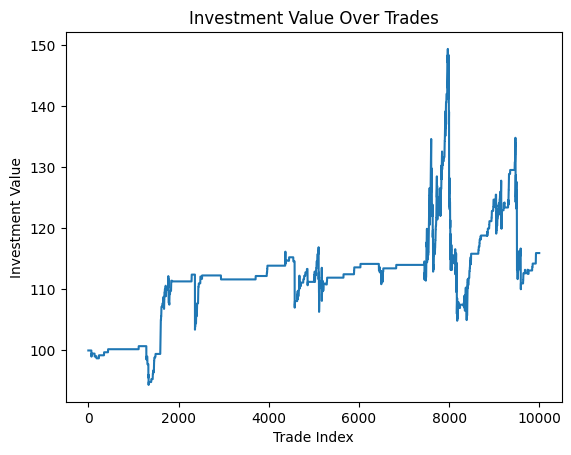

In [19]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.7
LEVERAGE = 1
GAIN = 0.5  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # A "bad" (wrong) trade
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = validation_dataset[f"{TICKER}:close4"][idx + 1]
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}%")
print(f"INVESTMENT VALUE: {round(current_investment, 2)}kr")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{TICKER}:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

In [ ]:
######################## OLD FILE #################################
##################### PROBABILITY ANALYSIS AND EXPECTED RETURNS
################# Probability analysis ###########################
import statistics as st

# Minimum required confidence for executing a trade
PROB_THRESH = 0.65
LEVERAGE = 1

# display(test_tabular_dataset)
# display(test_data_frame2[LABEL][len(labelled_data_frame) - VALIDATION_SIZE])


y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))
# display(y_prob)

counter = 0
correct = 0

predicted_high_list = []
predicted_low_list = []
predicted_close_list = []

balance = 100

hour_count = 0
month_gain = []
month = 100


first_index_dataset = len(labelled_data_frame) - VALIDATION_SIZE

print("------------------- TRADES: ------------------------------")
for index, pred in enumerate(y_pred):
    try:
        index = index + first_index_dataset
        prob = y_prob[1][index]
        actual = test_data_frame2["Label"][index]

        true_high = test_data_frame2[f"{TICKER}:high4"][index + 1]
        true_low = test_data_frame2[f"{TICKER}:low4"][index + 1]
        true_close = test_data_frame2[f"{TICKER}:close4"][index + 1]
        

        if prob > PROB_THRESH:
            counter += 1

            if pred == 1 and actual == 1:
                correct += 1
                predicted_high_list.append(true_high)
                predicted_low_list.append(true_low)
                predicted_close_list.append(true_close)

            ### LOGIC FOR CALCULATING GAIN ###
            if true_high >= 0.5:
                balance *= 1 + (0.005 * LEVERAGE)
                month *= 1 + (0.005 * LEVERAGE)
                print(f"{index}. Gain +5%")
            else:
                balance *= 1 + ((true_close / 100) * LEVERAGE)
                month *= 1 + ((true_close / 100) * LEVERAGE)
                #print(f"{index}. Close + {true_close} ---> High: {true_high}, Low: {true_low}, Close: {true_close}")
                print(f"{index}. Close +{true_close * LEVERAGE}")
    
        hour_count += 1
        if hour_count == 730:
            hour_count = 0
            month_gain.append(round(month - 100, 3))
            month = 100

    except Exception as e:
        print(f"Got following error: {e}")


month_gain.append(month - 100)

        

print("------------------------------------------")
print(f"Correct: {correct}")
print(f"Counter: {counter}")
print(f"Winrate: {correct / counter}")

print(f"AVG High: {st.mean(predicted_high_list)}")
print(f"AVG Low: {st.mean(predicted_low_list)}")
print(f"AVG Close: {st.mean(predicted_close_list)}")
print()
print(f"Balance: {balance}")
print(f"Return: {balance - 100}%")
print()
print(f"Month List: {month_gain}")
print(f"Mean month gain: {st.mean(month_gain)}")